In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class AnalysisSettings():
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        match self.dataset:
            case 'iris':
                self.label_pos = 4
                self.attribute_pos = [0, 1, 2, 3]
            case 'wine':
                self.label_pos = 0
                self.attribute_pos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
            case 'mnist':
                self.label_pos = 0
                self.attribute_pos = [i for i in range(1, 785)]
            

In [3]:
# Load data from dataset
settings = AnalysisSettings('iris')

org_dataset = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/original.csv', index_col=0)

## Standard deviation, $\sigma$, of inferred values on representational data

In [4]:
# Replacing the class names with numbers
classes = org_dataset['label'].unique()

stds = []
means = []

for i in range(len(classes)):
    samples = org_dataset[org_dataset['label'] == i].drop(['label'], axis=1).to_numpy()
    stds.append(np.std(samples, axis=0))
    means.append(np.mean(samples, axis=0))

# stds

In [5]:
# np.array(means).T

In [6]:
# Have the standard deviation per attribute per class now. 
# Need to get the inferred dataset and calculate the standard deviation of the inferred values

# Load data from dataset
sparsity = [0.01*i for i in range(1, 6)]

inferred_datasets = [] # Array of tuples with (mask, pcn_dataset, knn_dataset)
for s in sparsity:
    mask_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/' + str(s) + '/mask.csv', index_col=0)
    mask = mask_df.to_numpy()
    pcn_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/' + str(s) + '/pcn.csv', index_col=0)
    knn_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/' + str(s) + '/knn.csv', index_col=0)
    inferred_datasets.append((mask, pcn_df, knn_df))

In [7]:
def get_std(mask, dataset):
    mean_std = []
    std = np.divide(np.abs(dataset.drop(['label'], axis=1).to_numpy() - np.array(means)[dataset['label'].to_numpy()]), np.array(stds)[dataset['label'].to_numpy()])
    for i in range(len(classes)):
        index = dataset['label'] == i
        sub_mask = mask[index]
        basis = std[index] * sub_mask

        res = np.zeros_like(np.sum(basis, axis=0))
        res[:] = np.nan

        np.divide(np.sum(basis, axis=0), np.sum(sub_mask, axis=0), where=np.sum(sub_mask, axis=0) != 0, out=res)

        mean_std.append(res)
    return mean_std

In [8]:
mean_std_per_dataset_pcn = []
mean_std_per_dataset_knn = []
for mask, pcn_df, knn_df in inferred_datasets:
    mean_std_per_dataset_pcn.append(get_std(mask, pcn_df))
    mean_std_per_dataset_knn.append(get_std(mask, knn_df))

np.set_printoptions(precision=3, suppress=True)

np.nanmean(mean_std_per_dataset_pcn, axis=0).T


array([[ 2.828,  0.227,  1.255],
       [ 0.893,  0.71 ,  0.132],
       [17.811,  0.864,  3.433],
       [10.22 ,  0.852,  3.067]])

## Analysis of average accuracy of agents trained on reconstructed dataset

In [9]:
# Find mean accuracy on the control set
control_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/control_acc_test.csv', index_col=0)
# acc_ann_control, acc_pcn_control = control_df.mean(axis=0).values
acc_ann_control, acc_pcn_control, acc_ann_control_train, acc_pcn_control_train = control_df.mean(axis=0).values

In [10]:
# Find accuracy on sparse dataset of knn and pcn reconstructed datasets for each sparsity
test_accs_knn_ann = []
test_accs_knn_pcn = []
test_accs_pcn_ann = []
test_accs_pcn_pcn = []
train_accs_knn_ann = []
train_accs_knn_pcn = []
train_accs_pcn_ann = []
train_accs_pcn_pcn = []

test_accs = np.zeros((len(sparsity), 2, 2)) # Sparsity, PCN/KNN, PCN/ANN
train_accs = np.zeros((len(sparsity), 2, 2)) # Sparsity, PCN/KNN, PCN/ANN

TRAIN = 0
TEST = 0
PCN = 1
KNN = 0
ANN = 0

for i, s in enumerate(sparsity):
    knn_test_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/knn_reconstructed/' + str(s) + 'acc_test.csv', index_col=0)
    pcn_test_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/pcn_reconstructed/' + str(s) + 'acc_test.csv', index_col=0)

    knn_train_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/knn_reconstructed/' + str(s) + 'acc_train.csv', index_col=0)
    pcn_train_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/pcn_reconstructed/' + str(s) + 'acc_train.csv', index_col=0)
    
    knn_ann_test, knn_pcn_test = knn_test_df.mean().values
    pcn_ann_test, pcn_pcn_test = pcn_test_df.mean().values

    knn_ann_train, knn_pcn_train = knn_train_df.mean().values
    pcn_ann_train, pcn_pcn_train = pcn_train_df.mean().values

    test_accs[i, PCN] = pcn_test_df.mean().values
    test_accs[i, KNN] = knn_test_df.mean().values

    train_accs[i, PCN] = pcn_train_df.mean().values
    train_accs[i, KNN] = knn_train_df.mean().values

test_accs


array([[[0.95 , 0.788],
        [0.943, 0.798]],

       [[0.932, 0.77 ],
        [0.95 , 0.797]],

       [[0.948, 0.792],
        [0.947, 0.79 ]],

       [[0.94 , 0.785],
        [0.953, 0.785]],

       [[0.925, 0.787],
        [0.943, 0.792]]])

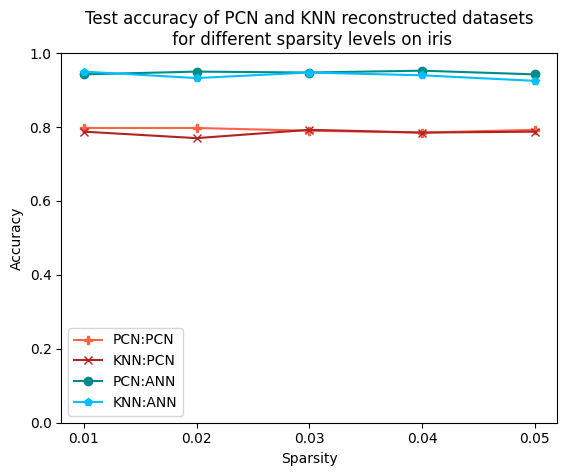

In [11]:
plt.plot(   sparsity, test_accs[:, PCN, PCN], color='tomato', label='PCN:PCN', marker='P')
plt.plot(   sparsity, test_accs[:, KNN, PCN], color='firebrick', label='KNN:PCN', marker='x')

plt.plot(   sparsity, test_accs[:, PCN, ANN], color='darkcyan', label='PCN:ANN', marker='o')
plt.plot(   sparsity, test_accs[:, KNN, ANN], color='deepskyblue', label='KNN:ANN', marker='p')

# plt.plot(sparsity, np.ones_like(sparsity)*acc_pcn_control, color='red', label='PCN control accuracy', linestyle='--')
# plt.plot(sparsity, np.ones_like(sparsity)*acc_ann_control, color='blue', label='ANN control accuracy', linestyle='--')

plt.title('Test accuracy of PCN and KNN reconstructed datasets\n for different sparsity levels on ' + settings.dataset)

plt.xlabel('Sparsity')
plt.xticks(sparsity)
plt.ylabel('Accuracy')

plt.ylim(0, 1)
plt.legend()
plt.savefig('./experiments/inference/image/sparsity_test_acc_comparison.png')

In [12]:
# Improvements
np.mean(test_accs, axis=0) - np.array([acc_ann_control, acc_pcn_control])

array([[-0.006, -0.028],
       [ 0.002, -0.02 ]])

In [13]:
# Importments on training set
np.mean(train_accs, axis=0) - np.array([acc_ann_control_train, acc_pcn_control_train])

array([[ 0.001, -0.012],
       [-0.006, -0.009]])

## Comparison between KNN and PCN reconstructed dataset

In [14]:
x_ticks = ['iris', 'wine', 'mnist']

acc_ann_knn = test_accs[4, KNN, ANN]
acc_ann_pcn = test_accs[4, PCN, ANN]

acc_pcn_knn = test_accs[4, KNN, PCN]
acc_pcn_pcn = test_accs[4, PCN, PCN]


In [15]:
pcn_df = pd.read_csv('./experiments/inference/results/analysis_acc_pcn.csv', index_col=0)
# temp = pd.DataFrame({settings.dataset: [acc_pcn_knn, acc_pcn_pcn]}, index=['KNN', 'PCN'])
# temp.to_csv('./experiments/inference/results/analysis_acc_pcn.csv')
# pcn_df[settings.dataset] = temp[settings.dataset]

# ann_df

# pcn_df.to_csv('./experiments/inference/results/analysis_acc_pcn.csv')

In [16]:
ann_df = pd.read_csv('./experiments/inference/results/analysis_acc_ann.csv', index_col=0)
# temp = pd.DataFrame({settings.dataset: [acc_ann_knn, acc_ann_pcn]}, index=['KNN', 'PCN'])
# temp.to_csv('./experiments/inference/results/analysis_acc_ann.csv')
# ann_df[settings.dataset] = temp[settings.dataset]

# ann_df

# ann_df.to_csv('./experiments/inference/results/analysis_acc_ann.csv')

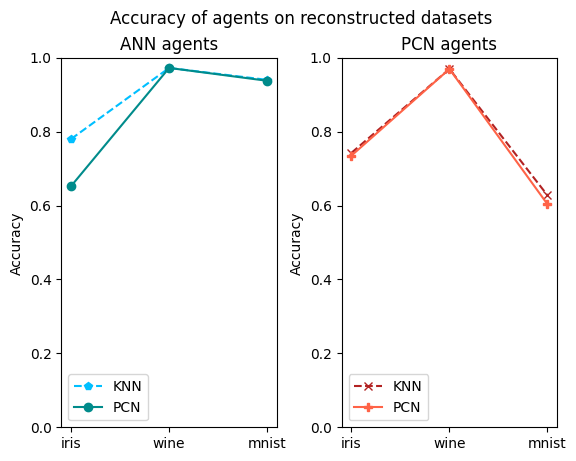

In [17]:
plt.subplot(121)
plt.plot(x_ticks, ann_df.loc['KNN'], color='deepskyblue', label='KNN', marker='p', linestyle='--')
plt.plot(x_ticks, ann_df.loc['PCN'], color='darkcyan', label='PCN', marker='o')
plt.title('ANN agents')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.subplot(122)
plt.plot(x_ticks, pcn_df.loc['KNN'], color='firebrick', label='KNN', marker='x', linestyle='--')
plt.plot(x_ticks, pcn_df.loc['PCN'], color='tomato', label='PCN', marker='P')
plt.title('PCN agents')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.subplots_adjust(wspace=0.3)
plt.suptitle('Accuracy of agents on reconstructed datasets')
plt.savefig('./experiments/inference/image/reconstructed_accs_comparison.png')

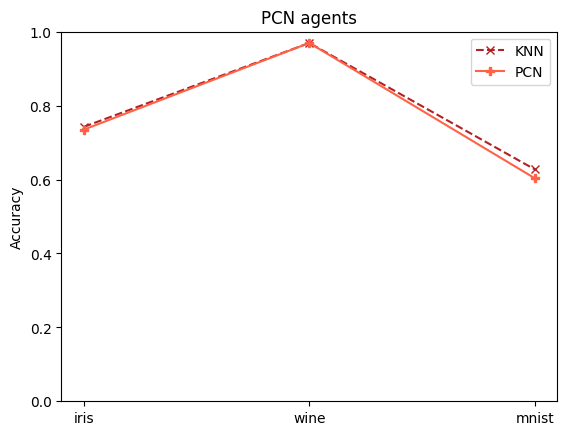

In [18]:
plt.plot(x_ticks, pcn_df.loc['KNN'], color='firebrick', label='KNN', marker='x', linestyle='--')
plt.plot(x_ticks, pcn_df.loc['PCN'], color='tomato', label='PCN', marker='P')
plt.title('PCN agents')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.savefig('./experiments/inference/image/reconstructed_accs_pcn.png')

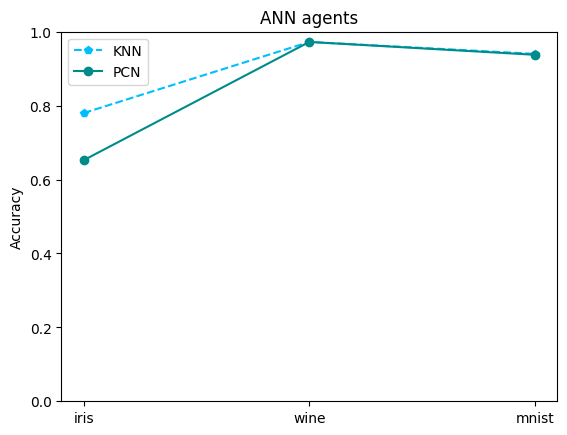

In [19]:
plt.plot(x_ticks, ann_df.loc['KNN'], color='deepskyblue', label='KNN', marker='p', linestyle='--')
plt.plot(x_ticks, ann_df.loc['PCN'], color='darkcyan', label='PCN', marker='o')
plt.title('ANN agents')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

# plt.show()
plt.savefig('./experiments/inference/image/reconstructed_accs_ann.png')